# Preprocesamiento EMNIST

- Reshape de 784 píxeles a matrices 28x28
- Normalización (invertir polaridad y escalar a [0, 1])
- Binarización por umbral de Otsu
- Extracción del ground truth en texto plano (usando el mapping de EMNIST)
- Uso del split original: 697,932 train / 116,323 test
- Extracción: 52 features (valentin)
- PCA 52 a 35-40 dimensiones (compensación de desbalance - class weight) 


## Imports

In [14]:
import numpy as np
import pandas as pd
from pathlib import Path
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

In [3]:
train_path = "../data/emnist-byclass-train.csv"
test_path = "../data/emnist-byclass-test.csv"

## Cargamos dataset EMNIST
Cada archivo CSV tiene **785 columnas**:
- Columna 0: etiqueta (label numérico)
- Columnas 1..784: valores de píxel en escala de grises [0, 255]

In [4]:
df_train = pd.read_csv(train_path, header=None)
df_test  = pd.read_csv(test_path, header=None)

print('Train shape:', df_train.shape)
print('Test shape :', df_test.shape)
df_train.head()

Train shape: (697932, 785)
Test shape : (116323, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,35,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Función de preprocesamiento

Esta función realiza:
1. Separación de labels (ground truth) y píxeles
2. Reshape a imágenes 28x28
3. Inversión de polaridad y normalización a [0, 1]
4. Binarización Otsu por imagen

In [ ]:
def preprocess_emnist(df):
    """Preprocesa un DataFrame EMNIST (ByClass).

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con shape (N, 785). Columna 0 = label.

    Devuelve
    --------
    X_bin_flat : np.ndarray, shape (N, 784)
        Imágenes binarizadas (0/1) aplanadas.
    X_bin_img : np.ndarray, shape (N, 28, 28)
        Imágenes binarizadas (0/1) en formato 2D.
    y : np.ndarray, shape (N,)
        Labels enteros.
    """
    # 1. Separar labels y píxeles
    y = df.iloc[:, 0].astype(np.int64).values
    X = df.iloc[:, 1:].astype(np.uint8).values  # [0, 255]

    # 2. Reshape a (N, 28, 28)
    X_img = X.reshape(-1, 28, 28)

    # 3. Invertir polaridad y normalizar
    # asumimos fondo blanco, letra negro
    X_inverted = 255 - X_img
    X_norm = X_inverted.astype(np.float32) / 255.0  # [0, 1]

    # 4. Binarización Otsu por imagen
    N = X_norm.shape[0]
    X_bin_img = np.empty_like(X_norm, dtype=np.uint8)

    for i in range(N):
        # umbral de Otsu en la imagen i
        thresh = threshold_otsu(X_norm[i])
        X_bin_img[i] = (X_norm[i] >= thresh).astype(np.uint8)

    # Aplanar a (N, 784) para modelos que esperan vectores
    X_bin_flat = X_bin_img.reshape(N, -1)

    return X_bin_flat, X_bin_img, y

## Ejecutar preprocesamiento en train y test

In [6]:
X_train_flat, X_train_img, y_train = preprocess_emnist(df_train)
X_test_flat,  X_test_img,  y_test  = preprocess_emnist(df_test)

print('Train binarizado:', X_train_flat.shape, y_train.shape)
print('Test  binarizado:', X_test_flat.shape,  y_test.shape)

Train binarizado: (697932, 784) (697932,)
Test  binarizado: (116323, 784) (116323,)


Label numérico: 35
Matriz 28x28 (valores 0/1):
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1]
 [1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1]
 [1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1]
 [1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1]
 [1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1]
 [1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1]
 [1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1]
 [1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1]
 [1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1]
 [1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1]
 [1 1 1 0

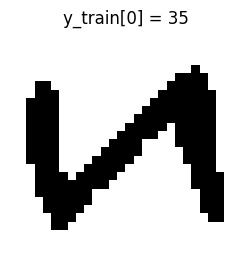

In [ ]:
# marca 1 como blanco, 0 como negro ya que hemos invertido
idx = 0  

print("Label numérico:", y_train[idx])
print("Matriz 28x28 (valores 0/1):")
print(X_train_img[idx])

plt.figure(figsize=(3, 3))
plt.imshow(X_train_img[idx], cmap="gray")
plt.title(f"y_train[{idx}] = {y_train[idx]}")
plt.axis("off")
plt.show()


Label numérico: 22
Matriz 28x28 (valores 0/1):
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [1 1 1 1

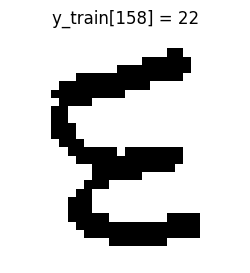

In [30]:
idx = 158

print("Label numérico:", y_train[idx])
print("Matriz 28x28 (valores 0/1):")
print(X_train_img[idx])

plt.figure(figsize=(3, 3))
plt.imshow(X_train_img[idx], cmap="gray")
plt.title(f"y_train[{idx}] = {y_train[idx]}")
plt.axis("off")
plt.show()

In [11]:
MAPPING_TXT = "../data/emnist-byclass-mapping.txt"

mapping_df = pd.read_csv(
    MAPPING_TXT,
    sep=" ",
    header=None,
    names=["label", "ascii"]
)

# convertir ascii (entero) a caracter
mapping_df["char"] = mapping_df["ascii"].apply(lambda x: chr(int(x)))

# diccionario: label entero -> caracter
label_to_char = dict(zip(mapping_df["label"], mapping_df["char"]))

print(mapping_df.head())
mapping_df.to_csv("ground_truth.txt", index=False)

   label  ascii char
0      0     48    0
1      1     49    1
2      2     50    2
3      3     51    3
4      4     52    4
